## cargamos el pandas

In [1]:
import pandas as pd
import numpy as np

para poder pintar con plot pylab

In [2]:
%pylab inline #esto permite a pandas pintar en el notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv('C:/Users/Juanpe/MachineLearningTest/data/train.csv')

In [ ]:
train.head(22)

In [ ]:
train.age.plot()

In [ ]:
train['age'].hist()

In [ ]:
train.hist(figsize=(20,20))

In [ ]:
train.boxplot('age')

In [ ]:
train.describe()

In [ ]:
train.iloc[21,2]

In [ ]:
train.loc[21,'age']

In [ ]:
train.shape

In [ ]:
train.info()

In [4]:
nrow = train.shape[0]

In [ ]:
len(train)

In [ ]:
train.num.unique()

vamos a hacer un for

In [5]:
for i in range(nrow):
    if train['num'][i] != 0:
        train.loc[i,'num'] = 1
        

In [ ]:
train

In [ ]:
range(nrow)

In [ ]:
train['num'][train['num']!=0]

In [ ]:
train.loc[2,'num']

In [ ]:
train

In [ ]:
train[train['num']!=0]

## Preprocessing 

http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values

#nos saltamos la estandarización
#vemos valores Nan

In [ ]:
pd.isnull(train).any(1).nonzero()[0]

In [ ]:
train.iloc[pd.isnull(train).any(1).nonzero()[0]]

In [ ]:
train.loc[[87, 166, 192],:]

#pillamos la librería q imputa valores

In [6]:
train = train.fillna(train.mean())#forma simplificada de Juan

In [ ]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train)

nos crea una matriz sin nombres de campo, por eso lo de columns

In [ ]:
train = pd.DataFrame(imp.transform(train),columns=train.columns)

In [16]:
train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,1
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,1
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


## vamos a ver cada variable cuántos son sanos

In [ ]:
train.groupby('num').size()

In [ ]:
train.num.mean() #hay un 43% de enfermos

In [ ]:
train.sex.mean() #hay un 67% de hombres

In [ ]:
train.groupby('sex').agg({'num': np.mean}) #sexo importa

In [ ]:
train.groupby('cp').agg({'num': np.mean}) # cp importa mucho

In [ ]:
train.groupby('fbs').agg({'num': np.mean}) #nada castaña pilonga

In [ ]:
train.groupby('restecg').agg({'num': np.mean}) # importa poco

In [ ]:
train.groupby('exang').agg({'num': np.mean}) # importa bastante

In [ ]:
train.groupby('slope').agg({'num': np.mean}) # importa bastante

In [17]:
train.groupby('ca').agg({'num': np.mean}) #importa demasiado!!

,num
ca,
0.000000,0.243590
0.671756,0.500000
1.000000,0.636364
2.000000,0.781250
3.000000,0.842105


In [18]:
train.groupby('thal').agg({'num': np.mean}) # importa bastante

,num
thal,
3.000000,0.213333
4.676806,0.000000
6.000000,0.545455
7.000000,0.754902


voy a pintar un mapa de correlaciones de variables

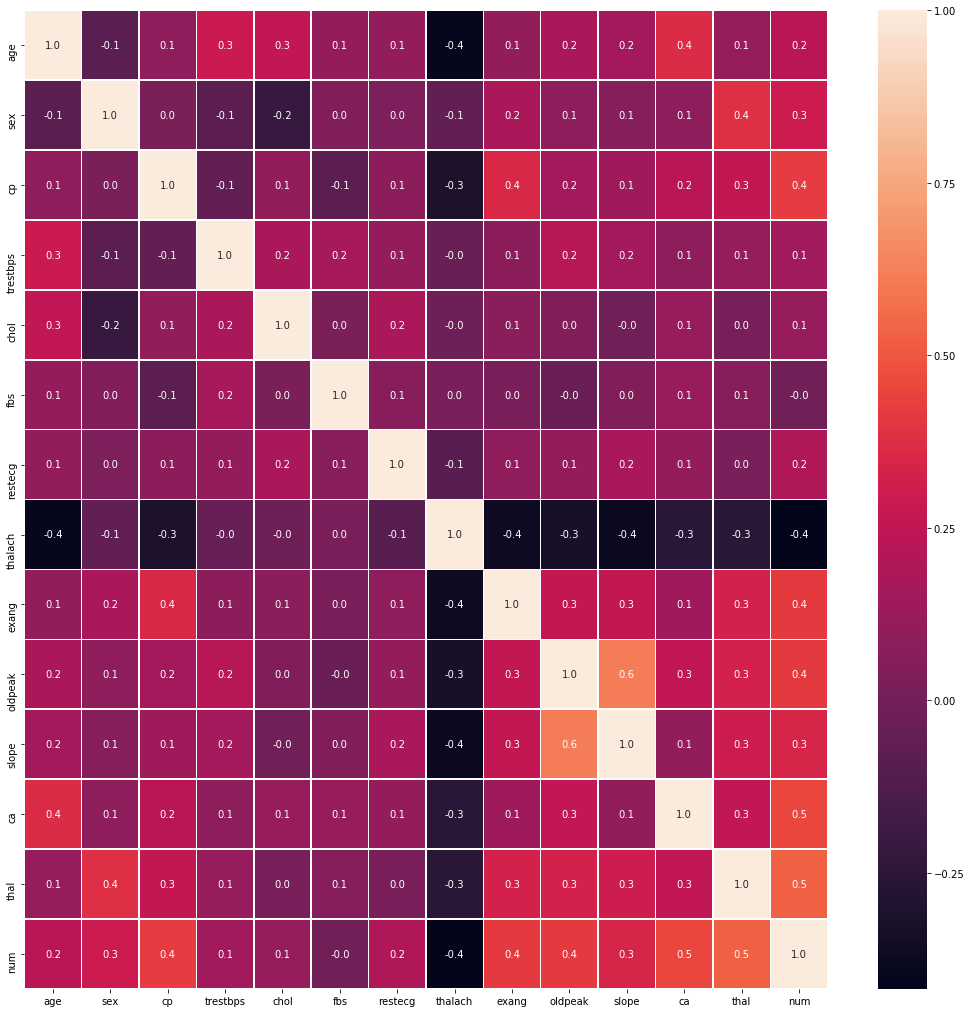

In [15]:
#correlation map
import seaborn as sns
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

sale lo q habia visto yo con los group by!!!!!!

## modelo encontrado por Miguel para ver importancia de variables

http://python-apuntes.blogspot.com.es/2016/07/importancia-variables.html

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
# CONVIERTE DATA.FRAME EN MATRIZ npy
# -------------------------------------------------------------------
dataset = train
clase_name = 'num' # nombre de variable a predecir
headers = dataset.columns.values.tolist()
headers.remove(clase_name)
clase   = dataset[clase_name].tolist() # array con variable a predecir
clase   = np.array(clase)


# MODELO
# -------------------------------------------------------------------
model = ExtraTreesClassifier()
model.fit(dataset, clase)


In [ ]:
# IMPORTANCIA VARIABLES
# -------------------------------------------------------------------
var_imp = pd.DataFrame[{
 'feature':headers, 
 'v_importance':model.feature_importances_.tolist()
 }]
var_imp.sort_values(by = 'v_importance', ascending=False)

## lanzamos modelo naive bayes

separamos los datos X, y (lo pasamos a forma matriz por Victor manía)

In [7]:
X, y = train.iloc[:,:-1].as_matrix(), train.iloc[:,-1].as_matrix()

y tb en train y test de ambas variables

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train


lanzamos modelo. copio y pego del scikit learn la forma

In [10]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

#print("Number of mislabeled points out of a total %d points : %d"% (X_train.shape[0],(y_train != y_pred).sum())) Number of mislabeled points out of a total 150 points : 6

## vemos la matriz de confusión

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

In [13]:
pd.DataFrame(cnf_matrix,columns=['no','si'], index=['no','si'])

,no,si
no,39,5
si,6,38


## qué valores da a cada variable?  
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [14]:
gnb.score(X_test, y_test)

0.875